# ITR: Similar images detection

**Tangxiaoxue Zhang**

## Method's Current Usage

MinHash is widely used as a scalable “find-similar-items” technique because it approximates set similarity (often Jaccard similarity) with compact signatures, enabling fast candidate generation without exhaustive pairwise comparisons. In recent peer-reviewed work, MinHash appears both as a practical system component and as an actively improved algorithmic primitive. For example, BigEye (Fahim et al., 2022) uses MinHash signatures (with LSH) to estimate similarity between distributed event clusters efficiently, so that a system can consolidate highly similar content and then retrieve representative visual summaries under bandwidth and compute constraints. In other words, MinHash is not only “for documents”—it is used as an engineering backbone for large-scale, real-world pipelines where similarity estimation has to be cheap enough to run continuously. A second line of work focuses on making MinHash faster and more deployable at scale. A 2024 paper (Peshevski et al., 2024) in Computing and Informatics presents GPU-parallel implementations of MinHash for near-duplicate detection, targeting the exact bottleneck that shows up when datasets become too large for CPU-only pipelines. Meanwhile, algorithmic refinements continue: C-MinHash (Li & Li, 2022) proposes a structured permutation strategy to improve minwise hashing efficiency while retaining the core resemblance-estimation goal—reflecting that MinHash remains a living method, not a solved problem.

For memorability and image-feature research, the most direct relevance is: near-duplicates and heavy overlap distort what we think we are measuring. If the dataset contains many “almost the same” images, then any estimate of what is “intrinsically memorable” can be contaminated by repeated exposure, training/test leakage, or over-represented visual motifs. This is exactly why large dataset releases increasingly include deduplication metadata (e.g., MinHash signatures) as part of reproducible ML practice, because deduplication reduces memorization and improves evaluation validity.  Importantly, deduplication itself can have social consequences: work like FairDeDup (Slyman et al., 2024) shows that deduplication choices in vision-language data can shift downstream bias/fairness outcomes, meaning “removing duplicates” is not socially neutral. 

Finally, PCA remains a standard companion to similarity search in image pipelines because modern image representations (CNN/ViT/CLIP features) are high-dimensional and expensive to store/search. A recent example, Compact DINO-ViT (Chandranegara et al., 2024) explicitly uses PCA to compress large transformer features while maintaining downstream performance, illustrating PCA’s continued role as a practical dimensionality-reduction tool for image-feature processing. 

## Test on my data

### Results

comb_score = (1 / max(sAC, sBC)-1)*10 + (min(sAC, sBC) - sAB)*magnify_index

In [ ]:
with open("protection") as f:
    print("running from the beginning would take a lot of time, please make sure run all is needed")

In [177]:
import json

with open("auc_dict.txt", "r") as f:
    auc_dict = json.load(f)

In [179]:
for key, value in auc_dict.items():
    print(f"{key}:")
    print(f"\tauc: {value['auc']}")
    print(f"\tmagnify_index: {value['magnify_index']}")
    print(f"\toptimal_threshold: {value['op_thre']}")

CLIP(without_PCA):
	auc: 0.9445312499999999
	magnify_index: 5.0
	optimal_threshold: {'op_thre': 0.45495222232051047, 'FPR': 0.1, 'TPR': 0.8125}
CLIP(with_PCA):
	auc: 0.9369791666666667
	magnify_index: 8.5
	optimal_threshold: {'op_thre': 1.1334527213918602, 'FPR': 0.08333333333333333, 'TPR': 0.8125}
Pixel(without_PCA):
	auc: 0.915625
	magnify_index: 2.0
	optimal_threshold: {'op_thre': 0.03404015923929782, 'FPR': 0.15, 'TPR': 0.9375}
Pixel(with_PCA):
	auc: 0.9151041666666666
	magnify_index: 0.0
	optimal_threshold: {'op_thre': 0.02883379620275628, 'FPR': 0.16666666666666666, 'TPR': 0.875}


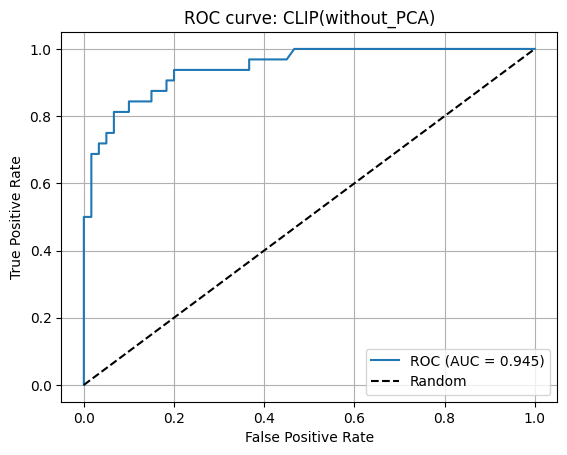

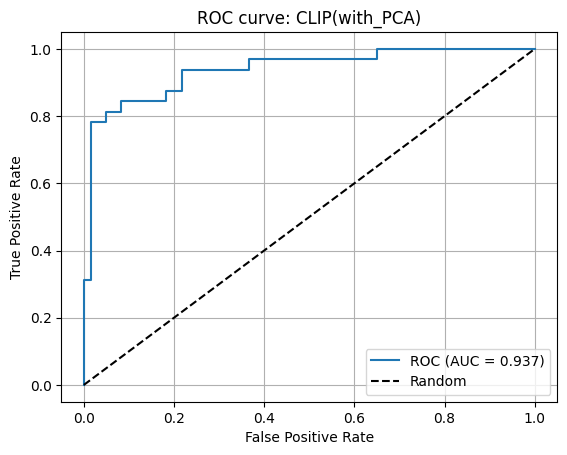

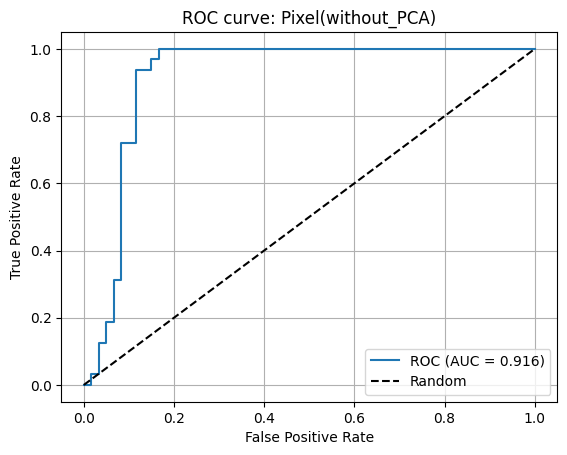

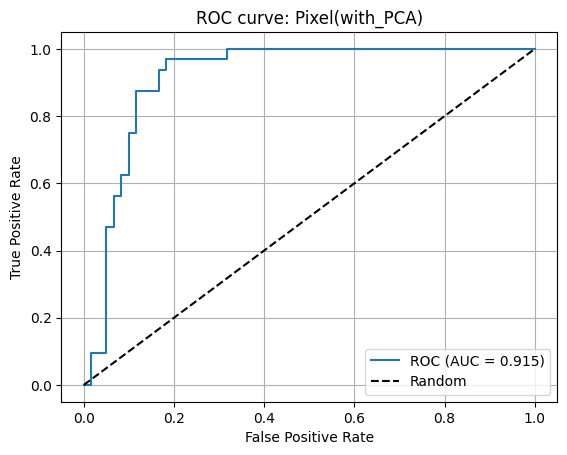

In [147]:
import matplotlib.pyplot as plt

for cat in cat_lst:
    auc_dict_tmp = auc_dict[cat]
    auc = auc_dict_tmp["auc"]
    y_true = auc_dict_tmp["y_true"]
    y_scores = auc_dict_tmp["y_scores"]
    roc_curve = auc_dict_tmp["roc_curve"]
    (fpr, tpr, label) = roc_curve

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curve: {cat}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [173]:
FPR = 0.13
label = cat_lst[3]

roc_par = auc_dict[label]["roc_curve"]
roc_fr = roc_par[0]

op_thre = 0
for index, fpr in enumerate(roc_fr):
    if fpr >= FPR:
        tpr = roc_par[1][index]
        op_thre = roc_par[2][index]
        break
auc_dict[label]["op_thre"] = {"op_thre": op_thre, "FPR": fpr, "TPR": tpr}

In [175]:
import json

with open("auc_dict.txt", "w") as f:
    json.dump(auc_dict, f, indent=4)

### Procedure

In [100]:
import sys
# import os
# dir = os.path.dirname(os.path.realpath('.'))
dir = '/project/wilma/katyzhang/CLIP/ViT-B-32.pt'
sys.path.append(dir)

In [101]:
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(
    "ViT-B/32",
    device=device,
    download_root="/project/wilma/katyzhang/CLIP"
)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [102]:
import json
with open("data/test_data.json") as f:
    data = json.load(f)

In [103]:
data

[{'grapefruit_10s': 0.9097368717193604,
  'granola_07s': 0.8094499111175537,
  'grapefruit_10s&&granola_07s_00001_': 0.8573886156082153,
  'tag': 'combination'},
 {'grapefruit_14s': 0.8613274097442627,
  'granola_04s': 0.9168999791145325,
  'grapefruit_14s&&granola_04s_00001_': 0.9069266319274902,
  'tag': 'copy of the 2nd image'},
 {'grapefruit_15s': 0.9553461670875549,
  'granola_14s': 0.844550609588623,
  'grapefruit_15s&&granola_14s_00001_': 0.8500057458877563,
  'tag': 'copy of the 2nd image'},
 {'grapefruit_02s': 0.9061657190322876,
  'granola_02s': 0.8754630088806152,
  'grapefruit_02s&&granola_02s_00001_': 0.9071510434150696,
  'tag': 'copy of the 1st image'},
 {'grapefruit_16n': 0.9285822510719299,
  'granola_15s': 0.8015612959861755,
  'grapefruit_16n&&granola_15s_00001_': 0.8180649876594543,
  'tag': 'combination'},
 {'grapefruit_08s': 0.8902026414871216,
  'granola_10s': 0.9353903532028198,
  'grapefruit_08s&&granola_10s_00001_': 0.9459294080734253,
  'tag': 'copy of the 1s

In [104]:
cat_lst = ["CLIP(without_PCA)", "CLIP(with_PCA)", "Pixel(without_PCA)", "Pixel(with_PCA)"]
auc_dict = {}

### CLIP + Without PCA

In [105]:
import PIL.Image as Image

def encode_image_openclip(img_path, device=device):
    image = Image.open(img_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_tensor)

    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    return image_features.squeeze(0)

In [106]:
def cosine_sim(v1, v2):
    return float((v1 * v2).sum())   # both are already L2-normalized

def analyze_triplet_clip(vA, vB, vC, magnify_index, thresh=0.15):
    tag = "none"
    sAB = cosine_sim(vA, vB)
    sAC = cosine_sim(vA, vC)
    sBC = cosine_sim(vB, vC)

    comb_score = (1 / max(sAC, sBC)-1)*10 + (min(sAC, sBC) - sAB)*magnify_index
    
    if comb_score > thresh:
        tag = "combination"
    else:
        tag = "copy"

    return {
        "sAB": sAB,
        "sAC": sAC,
        "sBC": sBC,
        "comb_score": float(comb_score),
        "tag": tag
    }

#### Find the optimal magnify_index

In [107]:
# Test which magnify_index is best
import os
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# Record lists
AUC_lst = []
result_CLIP_lst = []
y_true_lst = []
y_scores_lst = []
roc_curve_lst = []

test_lst = np.arange(0,10,0.5)
for magnify_index in test_lst:
    print(magnify_index)
    result_CLIP = []
    for (imgA_name, imgB_name, imgA_B_name, tag) in data: 
        concept_A = "_".join(imgA_name.split("_")[:-1])
        concept_B = "_".join(imgB_name.split("_")[:-1])
        concept_A_B = concept_A + "+" + concept_B
        vA = encode_image_openclip(os.path.join("data", concept_A, imgA_name+".jpg"))
        vB = encode_image_openclip(os.path.join("data", concept_B, imgB_name+".jpg"))
        vA_B = encode_image_openclip(os.path.join("data", concept_A_B, imgA_B_name+".png"))
        info = analyze_triplet_clip(vA, vB, vA_B, magnify_index)
        result_CLIP.append(info)
    result_CLIP_lst.append(result_CLIP)

    y_true = []    # 1 if real_tag == "combination", else 0
    y_scores = []  # comb_score
    for i in range(len(data)):
        real_tag = data[i]["tag"]
        res = result_CLIP[i]

        y_true.append(1 if real_tag == "combination" else 0)
        y_scores.append(res["comb_score"])
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    AUC_lst.append(auc)
    y_true_lst.append(y_true)
    y_scores_lst.append(y_scores)
    roc_curve_lst.append((fpr, tpr, thresholds))

0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5


#### Use the optimal magnify_index

In [108]:
optimal_index = AUC_lst.index(max(AUC_lst))
magnify_index = float(test_lst[optimal_index])
result_CLIP = result_CLIP_lst[optimal_index]
y_true = y_true_lst[optimal_index]
y_scores = y_scores[optimal_index]
roc_curve = roc_curve_lst[optimal_index]
(fpr, tpr, label) = roc_curve
auc_dict[cat_lst[0]] = {"auc": max(AUC_lst), 
                    "magnify_index": magnify_index,
                    "result": result_CLIP,
                    "y_true": y_true,
                    "y_scores": y_scores,
                    "roc_curve": roc_curve}

In [109]:
result_CLIP

[{'sAB': 0.7236328125,
  'sAC': 0.7294921875,
  'sBC': 0.9453125,
  'comb_score': 0.6078092716942152,
  'tag': 'combination'},
 {'sAB': 0.67138671875,
  'sAC': 0.69287109375,
  'sBC': 0.9892578125,
  'comb_score': 0.21601022643139123,
  'tag': 'combination'},
 {'sAB': 0.68896484375,
  'sAC': 0.685546875,
  'sBC': 0.99609375,
  'comb_score': 0.022125842524509665,
  'tag': 'copy'},
 {'sAB': 0.71240234375,
  'sAC': 0.99658203125,
  'sBC': 0.720703125,
  'comb_score': 0.07580081952780482,
  'tag': 'copy'},
 {'sAB': 0.6591796875,
  'sAC': 0.64892578125,
  'sBC': 0.978515625,
  'comb_score': 0.16829134699351211,
  'tag': 'combination'},
 {'sAB': 0.62060546875,
  'sAC': 0.6357421875,
  'sBC': 0.98291015625,
  'comb_score': 0.24955343975099353,
  'tag': 'combination'},
 {'sAB': 0.708984375,
  'sAC': 0.89697265625,
  'sBC': 0.853515625,
  'comb_score': 1.8712681171747425,
  'tag': 'combination'},
 {'sAB': 0.69921875,
  'sAC': 0.703125,
  'sBC': 0.990234375,
  'comb_score': 0.11815057938856066,


### CLIP + PCA

In [110]:
import numpy as np

# 1) Collect all unique image paths
all_paths = set()
for (imgA_name, imgB_name, imgA_B_name, _) in data: 
    concept_A = "_".join(imgA_name.split("_")[:-1])
    concept_B = "_".join(imgB_name.split("_")[:-1])
    concept_A_B = concept_A + "+" + concept_B
    all_paths.add(os.path.join("data", concept_A, imgA_name+".jpg"))
    all_paths.add(os.path.join("data", concept_B, imgB_name+".jpg"))
    all_paths.add(os.path.join("data", concept_A_B, imgA_B_name+".png"))

all_paths = sorted(all_paths)  # list, fixed order

# 2) Encode each image once
path_to_vec = {}
emb_list = []

for p in all_paths:
    v = encode_image_openclip(p, device=device)  # torch.Size([d])
    v_np = v.cpu().numpy()
    key = p.split("/")[-1]
    path_to_vec[key] = v_np
    emb_list.append(v_np)

X = np.stack(emb_list, axis=0)  # shape: (N, d)
print("Embedding matrix shape:", X.shape)

Embedding matrix shape: (262, 512)


In [111]:
from sklearn.decomposition import PCA

# reduced dimension,128
n_components = 128

pca = PCA(n_components=n_components, svd_solver="randomized", random_state=0)
pca.fit(X)   # learns projection from d -> n_components

,n_components,128
,copy,True
,whiten,False
,svd_solver,'randomized'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,0


In [112]:
X_red = pca.transform(X)  # (N, n_components)

# L2-normalize for cosine similarity
norms = np.linalg.norm(X_red, axis=1, keepdims=True)
X_red = X_red / norms

# map back: path -> reduced vector
path_to_vec_red = {
    p.split("/")[-1]: v for p, v in zip(all_paths, X_red)
}

In [113]:
def cosine_sim(u, v):
    return float(np.dot(u, v))   

def analyze_triplet_CLIP_pca(A, B, C, magnify_index, thresh=0.15):
    vA = path_to_vec_red[A]
    vB = path_to_vec_red[B]
    vC = path_to_vec_red[C]

    tag = "none"
    sAB = cosine_sim(vA, vB)
    sAC = cosine_sim(vA, vC)
    sBC = cosine_sim(vB, vC)

    comb_score = (1 / max(sAC, sBC)-1)*10 + (min(sAC, sBC) - sAB)*magnify_index
    
    if comb_score > thresh:
        tag = "combination"
    else:
        tag = "copy"

    return {
        "sAB": sAB,
        "sAC": sAC,
        "sBC": sBC,
        "comb_score": float(comb_score),
        "tag": tag
    }

#### Find the optimal magnify_index

In [114]:
# Test which magnify_index is best
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# Record lists
AUC_lst = []
result_CLIP_pca_lst = []
y_true_lst = []
y_scores_lst = []
roc_curve_lst = []

test_lst = np.arange(0,10,0.5)
for magnify_index in test_lst:
    print(magnify_index)
    result_CLIP_pca = []
    for (imgA_name, imgB_name, imgA_B_name, tag) in data: 
        info = analyze_triplet_CLIP_pca(imgA_name+".jpg", imgB_name+".jpg", imgA_B_name+".png", magnify_index)
        result_CLIP_pca.append(info)
    result_CLIP_pca_lst.append(result_CLIP_pca)

    y_true = []    # 1 if real_tag == "combination", else 0
    y_scores = []  # comb_score
    for i in range(len(data)):
        real_tag = data[i]["tag"]
        res = result_CLIP_pca[i]

        y_true.append(1 if real_tag == "combination" else 0)
        y_scores.append(res["comb_score"])
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    AUC_lst.append(auc)
    y_true_lst.append(y_true)
    y_scores_lst.append(y_scores)
    roc_curve_lst.append((fpr, tpr, thresholds))

0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5


#### Use the optimal magnify_index

In [115]:
optimal_index = AUC_lst.index(max(AUC_lst))
magnify_index = float(test_lst[optimal_index])
result_CLIP_pca = result_CLIP_pca_lst[optimal_index]
y_true = y_true_lst[optimal_index]
y_scores = y_scores[optimal_index]
roc_curve = roc_curve_lst[optimal_index]
(fpr, tpr, label) = roc_curve
auc_dict[cat_lst[1]] = {"auc": max(AUC_lst), 
                        "magnify_index": magnify_index,
                        "result": result_CLIP,
                        "y_true": y_true,
                        "y_scores": y_scores,
                        "roc_curve": roc_curve}

In [116]:
result_CLIP_pca

[{'sAB': 0.15809229718256454,
  'sAC': 0.2254489218409259,
  'sBC': 0.8892869792552638,
  'comb_score': 1.8174952338115502,
  'tag': 'combination'},
 {'sAB': 0.17333217218049113,
  'sAC': 0.21536576091633214,
  'sBC': 0.9778329854337001,
  'comb_score': 0.5839808080182884,
  'tag': 'combination'},
 {'sAB': 0.12230137362584256,
  'sAC': 0.11499817109453453,
  'sBC': 0.9941017385863208,
  'comb_score': -0.002744648352460924,
  'tag': 'copy'},
 {'sAB': 0.18977638376884443,
  'sAC': 0.9940803118351615,
  'sBC': 0.20205346888793493,
  'comb_score': 0.16390461901241848,
  'tag': 'combination'},
 {'sAB': 0.06191142622113973,
  'sAC': 0.07365211922316592,
  'sBC': 0.9651063957484625,
  'comb_score': 0.46134778163775325,
  'tag': 'combination'},
 {'sAB': -0.04497591969614945,
  'sAC': -0.0033745787995275167,
  'sBC': 0.9659111112721489,
  'comb_score': 0.7065309192008087,
  'tag': 'combination'},
 {'sAB': 0.15532785917447006,
  'sAC': 0.691951582448129,
  'sBC': 0.5994290011689937,
  'comb_scor

### directly compare: pixel by pixel & without PCA

In [117]:
import numpy as np
from PIL import Image

def load_image_pixels(path, size=None):
    """
    Load image, optionally resize, convert to RGB,
    return as float32 array in [0, 1].
    """
    img = Image.open(path).convert("RGB")
    if size is not None:
        img = img.resize(size, Image.BILINEAR)
    arr = np.asarray(img, dtype=np.float32) / 255.0  # shape: (H, W, 3)
    return arr

def image_to_vector(path, size=None):
    """
    Load image and flatten to 1D vector.
    """
    arr = load_image_pixels(path, size=size)
    return arr.reshape(-1)  # shape: (H*W*3,)

In [118]:
COMMON_SIZE = (224, 224)

In [119]:
def cosine_sim(u, v):
    """
    Cosine similarity between two 1D vectors.
    """
    num = np.dot(u, v)
    denom = np.linalg.norm(u) * np.linalg.norm(v)
    if denom == 0:
        return 0.0
    return float(num / denom)

def mse(u, v):
    """
    Mean squared error between two 1D vectors.
    Smaller = more similar.
    """
    diff = u - v
    return float(np.mean(diff * diff))

In [120]:
def analyze_triplet_pixels(vA, vB, vC, magnify_index, thresh=0.15):
    tag = "none"
    sAB = cosine_sim(vA, vB)
    sAC = cosine_sim(vA, vC)
    sBC = cosine_sim(vB, vC)

    comb_score = (1 / max(sAC, sBC)-1)*10 + (min(sAC, sBC) - sAB)*magnify_index
    
    if comb_score > thresh:
        tag = "combination"
    else:
        tag = "copy"

    return {
        "sAB": sAB,
        "sAC": sAC,
        "sBC": sBC,
        "comb_score": float(comb_score),
        "tag": tag
    }

#### Find the optimal magnify_index

In [121]:
# Test which magnify_index is best
import os
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# Record lists
AUC_lst = []
result_pixel_lst = []
y_true_lst = []
y_scores_lst = []
roc_curve_lst = []

test_lst = np.arange(0,10,0.5)
for magnify_index in test_lst:
    print(magnify_index)
    result_pixel = []
    for (imgA_name, imgB_name, imgA_B_name, tag) in data: 
        concept_A = "_".join(imgA_name.split("_")[:-1])
        concept_B = "_".join(imgB_name.split("_")[:-1])
        concept_A_B = concept_A + "+" + concept_B
        vA = image_to_vector(os.path.join("data", concept_A, imgA_name+".jpg"), COMMON_SIZE)
        vB = image_to_vector(os.path.join("data", concept_B, imgB_name+".jpg"), COMMON_SIZE)
        vA_B = image_to_vector(os.path.join("data", concept_A_B, imgA_B_name+".png"), COMMON_SIZE)
        info = analyze_triplet_pixels(vA, vB, vA_B, magnify_index)
        result_pixel.append(info)
    result_pixel_lst.append(result_pixel)

    y_true = []    # 1 if real_tag == "combination", else 0
    y_scores = []  # comb_score
    for i in range(len(data)):
        real_tag = data[i]["tag"]
        res = result_pixel[i]

        y_true.append(1 if real_tag == "combination" else 0)
        y_scores.append(res["comb_score"])
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    AUC_lst.append(auc)
    y_true_lst.append(y_true)
    y_scores_lst.append(y_scores)
    roc_curve_lst.append((fpr, tpr, thresholds))

0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5


#### Use the optimal magnify_index

In [122]:
optimal_index = AUC_lst.index(max(AUC_lst))
magnify_index = float(test_lst[optimal_index])
result_pixel = result_pixel_lst[optimal_index]
y_true = y_true_lst[optimal_index]
y_scores = y_scores[optimal_index]
roc_curve = roc_curve_lst[optimal_index]
(fpr, tpr, label) = roc_curve
auc_dict[cat_lst[2]] = {"auc": max(AUC_lst), 
                     "magnify_index": magnify_index,
                     "result": result_CLIP,
                     "y_true": y_true,
                     "y_scores": y_scores,
                     "roc_curve": roc_curve}

In [123]:
result_pixel

[{'sAB': 0.8333032131195068,
  'sAC': 0.8291469216346741,
  'sBC': 0.9896306395530701,
  'comb_score': 0.09646752419852866,
  'tag': 'copy'},
 {'sAB': 0.8277096152305603,
  'sAC': 0.8217250108718872,
  'sBC': 0.999285876750946,
  'comb_score': -0.0048228728622268235,
  'tag': 'copy'},
 {'sAB': 0.8845419883728027,
  'sAC': 0.8850123882293701,
  'sBC': 0.9993643760681152,
  'comb_score': 0.00730108177947697,
  'tag': 'copy'},
 {'sAB': 0.8605474829673767,
  'sAC': 0.9997867941856384,
  'sBC': 0.8580783605575562,
  'comb_score': -0.0028057320118946016,
  'tag': 'copy'},
 {'sAB': 0.6327292323112488,
  'sAC': 0.6417223811149597,
  'sBC': 0.9943857789039612,
  'comb_score': 0.07444548291704045,
  'tag': 'copy'},
 {'sAB': 0.8539182543754578,
  'sAC': 0.8381208181381226,
  'sBC': 0.9979955554008484,
  'comb_score': -0.011510167805353966,
  'tag': 'copy'},
 {'sAB': 0.8452258110046387,
  'sAC': 0.9702646136283875,
  'sBC': 0.8587949275970459,
  'comb_score': 0.33360500476390476,
  'tag': 'combina

### directly compare: pixel by pixel & PCA

In [124]:
import numpy as np
from PIL import Image

COMMON_SIZE = (224, 224)

def load_image_pixels(path, size=None):
    img = Image.open(path).convert("RGB")
    if size is not None:
        img = img.resize(size, Image.BILINEAR)
    arr = np.asarray(img, dtype=np.float32) / 255.0  # (H, W, 3)
    return arr

def image_to_vector(path, size=None):
    arr = load_image_pixels(path, size=size)
    return arr.reshape(-1)  # (H*W*3,)

In [125]:
from sklearn.decomposition import PCA

# 1) all unique image paths
all_paths = set()
for (imgA_name, imgB_name, imgA_B_name, _) in data: 
    concept_A = "_".join(imgA_name.split("_")[:-1])
    concept_B = "_".join(imgB_name.split("_")[:-1])
    concept_A_B = concept_A + "+" + concept_B
    all_paths.add(os.path.join("data", concept_A, imgA_name+".jpg"))
    all_paths.add(os.path.join("data", concept_B, imgB_name+".jpg"))
    all_paths.add(os.path.join("data", concept_A_B, imgA_B_name+".png"))

all_paths = sorted(all_paths)  # list, fixed order

# 2) pixel vectors
path_to_pixel_vec = {}
vecs = []

for p in all_paths:
    v = image_to_vector(p, size=COMMON_SIZE)  # shape (D,)
    key = p.split("/")[-1]
    path_to_pixel_vec[key] = v
    vecs.append(v)

X = np.stack(vecs, axis=0)  # shape (N, D)
print("Pixel matrix shape:", X.shape)

# 3) PCA
n_components = 128

pca = PCA(n_components=n_components,
          svd_solver="randomized",
          random_state=0)
pca.fit(X)  # learn projection

Pixel matrix shape: (262, 150528)


,n_components,128
,copy,True
,whiten,False
,svd_solver,'randomized'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,0


In [126]:
X_red = pca.transform(X)  # shape (N, n_components)

# L2-normalize for cosine similarity
norms = np.linalg.norm(X_red, axis=1, keepdims=True)
X_red = X_red / norms

# map back path -> reduced vector
path_to_vec_red = {
    p.split("/")[-1]: v_red for p, v_red in zip(all_paths, X_red)
}

In [127]:
def cosine_sim(u, v):
    return float(np.dot(u, v))  # u, v are normalized

def analyze_triplet_pixels_pca(A, B, C, magnify_index, thresh=0.15):
    vA = path_to_vec_red[A]
    vB = path_to_vec_red[B]
    vC = path_to_vec_red[C]

    tag = "none"
    sAB = cosine_sim(vA, vB)
    sAC = cosine_sim(vA, vC)
    sBC = cosine_sim(vB, vC)

    comb_score = (1 / max(sAC, sBC)-1)*10 + (min(sAC, sBC) - sAB)*magnify_index
    
    if comb_score > thresh:
        tag = "combination"
    else:
        tag = "copy"

    return {
        "sAB": sAB,
        "sAC": sAC,
        "sBC": sBC,
        "comb_score": float(comb_score),
        "tag": tag
    }

#### Find the optimal magnify_index

In [128]:
# Test which magnify_index is best
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# Record lists
AUC_lst = []
result_pixel_pca_lst = []
y_true_lst = []
y_scores_lst = []
roc_curve_lst = []

test_lst = np.arange(0,10,0.5)
for magnify_index in test_lst:
    print(magnify_index)
    result_pixel_pca = []
    for (imgA_name, imgB_name, imgA_B_name, tag) in data: 
        info = info = analyze_triplet_pixels_pca(imgA_name+".jpg", imgB_name+".jpg", imgA_B_name+".png", magnify_index)
        result_pixel_pca.append(info)
    result_pixel_pca_lst.append(result_pixel_pca)

    y_true = []    # 1 if real_tag == "combination", else 0
    y_scores = []  # comb_score
    for i in range(len(data)):
        real_tag = data[i]["tag"]
        res = result_pixel_pca[i]

        y_true.append(1 if real_tag == "combination" else 0)
        y_scores.append(res["comb_score"])
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    AUC_lst.append(auc)
    y_true_lst.append(y_true)
    y_scores_lst.append(y_scores)
    roc_curve_lst.append((fpr, tpr, thresholds))

0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5


#### Use the optimal magnify_index

In [129]:
optimal_index = AUC_lst.index(max(AUC_lst))
magnify_index = float(test_lst[optimal_index])
result_pixel_pca = result_pixel_pca_lst[optimal_index]
y_true = y_true_lst[optimal_index]
y_scores = y_scores[optimal_index]
roc_curve = roc_curve_lst[optimal_index]
(fpr, tpr, label) = roc_curve
auc_dict[cat_lst[3]] = {"auc": max(AUC_lst), 
                         "magnify_index": magnify_index,
                         "result": result_CLIP,
                         "y_true": y_true,
                         "y_scores": y_scores,
                         "roc_curve": roc_curve}

In [130]:
result_pixel_pca

[{'sAB': 0.09227012097835541,
  'sAC': 0.13960741460323334,
  'sBC': 0.9870599508285522,
  'comb_score': 0.13109689194243712,
  'tag': 'copy'},
 {'sAB': 0.09171625971794128,
  'sAC': 0.09427053481340408,
  'sBC': 0.9983128309249878,
  'comb_score': 0.01690020425209715,
  'tag': 'copy'},
 {'sAB': 0.3200761675834656,
  'sAC': 0.35447216033935547,
  'sBC': 0.9984675049781799,
  'comb_score': 0.015348471674634379,
  'tag': 'copy'},
 {'sAB': 0.3284767270088196,
  'sAC': 0.9990769624710083,
  'sBC': 0.3434743285179138,
  'comb_score': 0.009238903144246358,
  'tag': 'copy'},
 {'sAB': -0.4085538983345032,
  'sAC': -0.37225982546806335,
  'sBC': 0.9910492897033691,
  'comb_score': 0.09031549075939393,
  'tag': 'copy'},
 {'sAB': -0.11826108396053314,
  'sAC': -0.10627570748329163,
  'sBC': 0.995692253112793,
  'comb_score': 0.04326383853786142,
  'tag': 'copy'},
 {'sAB': 0.3694644272327423,
  'sAC': 0.9255298376083374,
  'sBC': 0.4594224691390991,
  'comb_score': 0.8046219512933361,
  'tag': 'co

In [ ]:
import json
import numpy as np

def to_builtin(obj):
    '''numpy -> json_friendly_type'''
    if isinstance(obj, np.generic):
        return obj.item()
    if isinstance(obj, np.ndarray):
        return [to_builtin(x) for x in obj.tolist()]
    if isinstance(obj, dict):
        return {k: to_builtin(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [to_builtin(x) for x in obj]
    if isinstance(obj, tuple):
        return [to_builtin(x) for x in obj]
    return obj

clean_data = to_builtin(auc_dict)

with open("auc_dict.txt", "w") as f:
    json.dump(clean_data, f, indent=4)

In [181]:
clean_data

{'CLIP(without_PCA)': {'auc': 0.9445312499999999,
  'magnify_index': 5.0,
  'result': [{'sAB': 0.7236328125,
    'sAC': 0.7294921875,
    'sBC': 0.9453125,
    'comb_score': 0.6078092716942152,
    'tag': 'combination'},
   {'sAB': 0.67138671875,
    'sAC': 0.69287109375,
    'sBC': 0.9892578125,
    'comb_score': 0.21601022643139123,
    'tag': 'combination'},
   {'sAB': 0.68896484375,
    'sAC': 0.685546875,
    'sBC': 0.99609375,
    'comb_score': 0.022125842524509665,
    'tag': 'copy'},
   {'sAB': 0.71240234375,
    'sAC': 0.99658203125,
    'sBC': 0.720703125,
    'comb_score': 0.07580081952780482,
    'tag': 'copy'},
   {'sAB': 0.6591796875,
    'sAC': 0.64892578125,
    'sBC': 0.978515625,
    'comb_score': 0.16829134699351211,
    'tag': 'combination'},
   {'sAB': 0.62060546875,
    'sAC': 0.6357421875,
    'sBC': 0.98291015625,
    'comb_score': 0.24955343975099353,
    'tag': 'combination'},
   {'sAB': 0.708984375,
    'sAC': 0.89697265625,
    'sBC': 0.853515625,
    'comb_

### Usage

#### memorability for 4 groups

In [1]:
import sys

dir_concept_img = "/project/wilma/katyzhang/resmem/object_images"
dir_combination_img = "/project/wilma/katyzhang/resmem/Pictures_4"
dir_cluster_weapon_img = "/project/wilma/katyzhang/resmem/Pictures_cluster_weapon"
dir_weapon_img = "/project/wilma/katyzhang/resmem/Pictures_weapon"

sys.path.append(dir_concept_img)
sys.path.append(dir_combination_img)
sys.path.append(dir_cluster_weapon_img)
sys.path.append(dir_weapon_img)

In [42]:
with open("data/pairs.txt") as f:
    pairs = f.readlines()

with open("data/group_dict.json") as f:
    group_pars = json.load(f)

In [34]:
group_pars

{'grapefruit+granola': ['HS', 0.9748241713933846],
 'coffee_bean+coffee': ['HS', 0.9393628685422709],
 'roll+airbag': ['HS', 0.9308706440558693],
 'poinsettia+airbag': ['HS', 0.9305323018157886],
 'penlight+penholder': ['HS', 0.9267487898571626],
 'revolver+nail_clippers': ['HS', 0.9204037782291271],
 'nail_clippers+jukebox': ['HS', 0.9184441732443607],
 'revolver+jukebox': ['HS', 0.91635634421389],
 'pineapple+pine_tree': ['HS', 0.9163399876213137],
 'wallpaper+tape_recorder': ['HS', 0.9143269933266321],
 'taffy+tadpole': ['HS', 0.912470720030395],
 'kangaroo+canoe': ['HS', 0.9110829966705449],
 'stiletto+starfish': ['HS', 0.9101965290089883],
 'printer+hobbyhorse': ['HS', 0.9055822674378285],
 'stir_fry+stingray': ['HS', 0.9036130692136678],
 'swab+bikini': ['HS', 0.9023323376211904],
 'vegetable+cello': ['HS', 0.8994121083571043],
 'tape_recorder+pantsuit': ['HS', 0.8984226787893091],
 'kiwi+ankle': ['HS', 0.8966333340787033],
 'roll+poinsettia': ['HS', 0.8929408320256588],
 'punchi

In [53]:
# High semantic similarity, Same category
# Low  semantic similarity, Same category
# High semantic similarity, Different category
# Low  semantic similarity, Different category

group_dict = {}
semantic_sim = {}
for index, row in enumerate(pairs):
    concept = row.split(", ")
    comb = concept[0].replace(" ","_") + "+" + concept[1][:-1].replace(" ","_")
    group_dict[comb] = group_pars[comb][0]
    semantic_sim[comb] = group_pars[comb][1]

In [45]:
import json
with open("data/memorability_fullname.json") as f:
    group_memo_lst = json.load(f)

In [46]:
import json
with open("auc_dict.txt", "r") as f:
    auc_dict = json.load(f)

##### Attach the labels

In [11]:
import sys
import os
dir = '/project/wilma/katyzhang/CLIP/ViT-B-32.pt'

sys.path.append(dir)

In [7]:
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(
    "ViT-B/32",
    device=device,
    download_root="/project/wilma/katyzhang/CLIP"
)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

##### CLIP without PCA

In [8]:
import PIL.Image as Image

def encode_image_openclip(img_path, device=device):
    image = Image.open(img_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_tensor)

    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    return image_features.squeeze(0)

In [9]:
def cosine_sim(v1, v2):
    return float((v1 * v2).sum())   # both are already L2-normalized

def analyze_triplet_clip(vA, vB, vC, magnify_index, thresh=0.15):
    tag = "none"
    sAB = cosine_sim(vA, vB)
    sAC = cosine_sim(vA, vC)
    sBC = cosine_sim(vB, vC)

    comb_score = (1 / max(sAC, sBC)-1)*10 + (min(sAC, sBC) - sAB)*magnify_index
    
    if comb_score > thresh:
        tag = "combination"
    else:
        tag = "copy"

    return {
        "sAB": sAB,
        "sAC": sAC,
        "sBC": sBC,
        "comb_score": float(comb_score),
        "tag": tag
    }

In [ ]:
group_tag = []
semantic_sim_lst = []
result_CLIP = []
op_thre = auc_dict["CLIP(without_PCA)"]["op_thre"]["op_thre"]
magnify_index = auc_dict["CLIP(without_PCA)"]["magnify_index"]

for (imgA_name, imgB_name, imgA_B_name) in group_memo_lst: 
    concept_A = "_".join(imgA_name.split("_")[:-1])
    concept_B = "_".join(imgB_name.split("_")[:-1])
    concept_A_B = concept_A + "+" + concept_B
    group_tag.append(group_dict[concept_A_B])
    semantic_sim_lst.append(semantic_sim[concept_A_B])

    vA = encode_image_openclip(os.path.join(dir_concept_img, concept_A, imgA_name+".jpg"))
    vB = encode_image_openclip(os.path.join(dir_concept_img, concept_B, imgB_name+".jpg"))
    vA_B = encode_image_openclip(os.path.join(dir_combination_img, concept_A_B, imgA_B_name+".png"))
    info = analyze_triplet_clip(vA, vB, vA_B, magnify_index, op_thre)
    result_CLIP.append(info)

##### CLIP + PCA

In [13]:
import numpy as np

# 1) Collect all unique image paths
all_paths = set()
for (imgA_name, imgB_name, imgA_B_name) in group_memo_lst: 
    concept_A = "_".join(imgA_name.split("_")[:-1])
    concept_B = "_".join(imgB_name.split("_")[:-1])
    concept_A_B = concept_A + "+" + concept_B
    all_paths.add(os.path.join(dir_concept_img, concept_A, imgA_name+".jpg"))
    all_paths.add(os.path.join(dir_concept_img, concept_B, imgB_name+".jpg"))
    all_paths.add(os.path.join(dir_combination_img, concept_A_B, imgA_B_name+".png"))

all_paths = sorted(all_paths)  # list, fixed order

# 2) Encode each image once
path_to_vec = {}
emb_list = []

for p in all_paths:
    v = encode_image_openclip(p, device=device)  # torch.Size([d])
    v_np = v.cpu().numpy()
    key = p.split("/")[-1]
    path_to_vec[key] = v_np
    emb_list.append(v_np)

X = np.stack(emb_list, axis=0)  # shape: (N, d)
print("Embedding matrix shape:", X.shape)

Embedding matrix shape: (4719, 512)


In [14]:
from sklearn.decomposition import PCA

# reduced dimension,128
n_components = 128

pca = PCA(n_components=n_components, svd_solver="randomized", random_state=0)
pca.fit(X)   # learns projection from d -> n_components

,n_components,128
,copy,True
,whiten,False
,svd_solver,'randomized'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,0


In [15]:
X_red = pca.transform(X)  # (N, n_components)

# L2-normalize for cosine similarity
norms = np.linalg.norm(X_red, axis=1, keepdims=True)
X_red = X_red / norms

# map back: path -> reduced vector
path_to_vec_red = {
    p.split("/")[-1]: v for p, v in zip(all_paths, X_red)
}

In [16]:
def cosine_sim(u, v):
    return float(np.dot(u, v))   

def analyze_triplet_CLIP_pca(A, B, C, magnify_index, thresh=0.15):
    vA = path_to_vec_red[A]
    vB = path_to_vec_red[B]
    vC = path_to_vec_red[C]

    tag = "none"
    sAB = cosine_sim(vA, vB)
    sAC = cosine_sim(vA, vC)
    sBC = cosine_sim(vB, vC)

    comb_score = (1 / max(sAC, sBC)-1)*10 + (min(sAC, sBC) - sAB)*magnify_index
    
    if comb_score > thresh:
        tag = "combination"
    else:
        tag = "copy"

    return {
        "sAB": sAB,
        "sAC": sAC,
        "sBC": sBC,
        "comb_score": float(comb_score),
        "tag": tag
    }

In [17]:
result_CLIP_pca = []
op_thre = auc_dict["CLIP(with_PCA)"]["op_thre"]["op_thre"]
magnify_index = auc_dict["CLIP(with_PCA)"]["magnify_index"]

for (imgA_name, imgB_name, imgA_B_name) in group_memo_lst: 
    info = analyze_triplet_CLIP_pca(imgA_name+".jpg", imgB_name+".jpg", imgA_B_name+".png", magnify_index, op_thre)
    result_CLIP_pca.append(info)

##### Pixel without PCA

In [18]:
import numpy as np
from PIL import Image

def load_image_pixels(path, size=None):
    """
    Load image, optionally resize, convert to RGB,
    return as float32 array in [0, 1].
    """
    img = Image.open(path).convert("RGB")
    if size is not None:
        img = img.resize(size, Image.BILINEAR)
    arr = np.asarray(img, dtype=np.float32) / 255.0  # shape: (H, W, 3)
    return arr

def image_to_vector(path, size=None):
    """
    Load image and flatten to 1D vector.
    """
    arr = load_image_pixels(path, size=size)
    return arr.reshape(-1)  # shape: (H*W*3,)

In [19]:
COMMON_SIZE = (224, 224)

In [20]:
def cosine_sim(u, v):
    """
    Cosine similarity between two 1D vectors.
    """
    num = np.dot(u, v)
    denom = np.linalg.norm(u) * np.linalg.norm(v)
    if denom == 0:
        return 0.0
    return float(num / denom)

def mse(u, v):
    """
    Mean squared error between two 1D vectors.
    Smaller = more similar.
    """
    diff = u - v
    return float(np.mean(diff * diff))

In [21]:
def analyze_triplet_pixels(vA, vB, vC, magnify_index, thresh=0.15):
    tag = "none"
    sAB = cosine_sim(vA, vB)
    sAC = cosine_sim(vA, vC)
    sBC = cosine_sim(vB, vC)

    comb_score = (1 / max(sAC, sBC)-1)*10 + (min(sAC, sBC) - sAB)*magnify_index
    
    if comb_score > thresh:
        tag = "combination"
    else:
        tag = "copy"

    return {
        "sAB": sAB,
        "sAC": sAC,
        "sBC": sBC,
        "comb_score": float(comb_score),
        "tag": tag
    }

In [22]:
result_pixel = []
op_thre = auc_dict["Pixel(without_PCA)"]["op_thre"]["op_thre"]
magnify_index = auc_dict["Pixel(without_PCA)"]["magnify_index"]

for (imgA_name, imgB_name, imgA_B_name) in group_memo_lst: 
    concept_A = "_".join(imgA_name.split("_")[:-1])
    concept_B = "_".join(imgB_name.split("_")[:-1])
    concept_A_B = concept_A + "+" + concept_B
    vA = image_to_vector(os.path.join(dir_concept_img, concept_A, imgA_name+".jpg"), COMMON_SIZE)
    vB = image_to_vector(os.path.join(dir_concept_img, concept_B, imgB_name+".jpg"), COMMON_SIZE)
    vA_B = image_to_vector(os.path.join(dir_combination_img, concept_A_B, imgA_B_name+".png"), COMMON_SIZE)
    info = analyze_triplet_pixels(vA, vB, vA_B, magnify_index, op_thre)
    result_pixel.append(info)

##### Pixel with PCA

In [23]:
import numpy as np
from PIL import Image

COMMON_SIZE = (224, 224)

def load_image_pixels(path, size=None):
    img = Image.open(path).convert("RGB")
    if size is not None:
        img = img.resize(size, Image.BILINEAR)
    arr = np.asarray(img, dtype=np.float32) / 255.0  # (H, W, 3)
    return arr

def image_to_vector(path, size=None):
    arr = load_image_pixels(path, size=size)
    return arr.reshape(-1)  # (H*W*3,)

In [24]:
from sklearn.decomposition import PCA

# 1) all unique image paths
if not all_paths:
    all_paths = set()
    for (imgA_name, imgB_name, imgA_B_name) in group_memo_lst: 
        concept_A = "_".join(imgA_name.split("_")[:-1])
        concept_B = "_".join(imgB_name.split("_")[:-1])
        concept_A_B = concept_A + "+" + concept_B
        all_paths.add(os.path.join(dir_concept_img, concept_A, imgA_name+".jpg"))
        all_paths.add(os.path.join(dir_concept_img, concept_B, imgB_name+".jpg"))
        all_paths.add(os.path.join(dir_combination_img, concept_A_B, imgA_B_name+".png"))

    all_paths = sorted(all_paths)  # list, fixed order

# 2) pixel vectors
path_to_pixel_vec = {}
vecs = []

for p in all_paths:
    v = image_to_vector(p, size=COMMON_SIZE)  # shape (D,)
    key = p.split("/")[-1]
    path_to_pixel_vec[key] = v
    vecs.append(v)

X = np.stack(vecs, axis=0)  # shape (N, D)
print("Pixel matrix shape:", X.shape)

# 3) PCA
n_components = 128

pca = PCA(n_components=n_components,
          svd_solver="randomized",
          random_state=0)
pca.fit(X)  # learn projection

Pixel matrix shape: (4719, 150528)


,n_components,128
,copy,True
,whiten,False
,svd_solver,'randomized'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,0


In [25]:
X_red = pca.transform(X)  # shape (N, n_components)

# L2-normalize for cosine similarity
norms = np.linalg.norm(X_red, axis=1, keepdims=True)
X_red = X_red / norms

# map back path -> reduced vector
path_to_vec_red = {
    p.split("/")[-1]: v_red for p, v_red in zip(all_paths, X_red)
}

In [26]:
def cosine_sim(u, v):
    return float(np.dot(u, v))  # u, v are normalized

def analyze_triplet_pixels_pca(A, B, C, magnify_index, thresh=0.15):
    vA = path_to_vec_red[A]
    vB = path_to_vec_red[B]
    vC = path_to_vec_red[C]

    tag = "none"
    sAB = cosine_sim(vA, vB)
    sAC = cosine_sim(vA, vC)
    sBC = cosine_sim(vB, vC)

    comb_score = (1 / max(sAC, sBC)-1)*10 + (min(sAC, sBC) - sAB)*magnify_index
    
    if comb_score > thresh:
        tag = "combination"
    else:
        tag = "copy"

    return {
        "sAB": sAB,
        "sAC": sAC,
        "sBC": sBC,
        "comb_score": float(comb_score),
        "tag": tag
    }

In [27]:
result_pixel_pca = []
op_thre = auc_dict["Pixel(with_PCA)"]["op_thre"]["op_thre"]
magnify_index = auc_dict["Pixel(with_PCA)"]["magnify_index"]

for (imgA_name, imgB_name, imgA_B_name) in group_memo_lst: 
    info = info = analyze_triplet_pixels_pca(imgA_name+".jpg", imgB_name+".jpg", imgA_B_name+".png", magnify_index, op_thre)
    result_pixel_pca.append(info)

In [ ]:
for index, dict in enumerate(group_memo_lst):
    dict["group"] = group_tag[index]
    dict["Semantic_Similarity"] = semantic_sim_lst[index]
    dict["CLIP"] = result_CLIP[index]
    dict["CLIP_pca"] = result_CLIP_pca[index]
    dict["Pixel"] = result_pixel[index]
    dict["Pixel_pca"] = result_pixel_pca[index]

In [63]:
import json
with open("data/memorability_tagged.json", "w") as f:
    json.dump(group_memo_lst, f, indent=4)

In [30]:
group_memo_lst

[{'grapefruit_10s': 0.9097368717193604,
  'granola_07s': 0.8094499111175537,
  'grapefruit_10s&&granola_07s_00001_': 0.8573886156082153,
  'group': 'HS',
  'CLIP': {'sAB': 0.7229911684989929,
   'sAC': 0.7291331887245178,
   'sBC': 0.9448032975196838,
   'comb_score': 0.6149237953983744,
   'tag': 'combination'},
  'CLIP_pca': {'sAB': 0.2521896958351135,
   'sAC': 0.2883053123950958,
   'sBC': 0.8965233564376831,
   'comb_score': 1.4611818234639422,
   'tag': 'combination'},
  'Pixel': {'sAB': 0.8333032131195068,
   'sAC': 0.8291469216346741,
   'sBC': 0.9896306395530701,
   'comb_score': 0.09646752419852866,
   'tag': 'combination'},
  'Pixel_pca': {'sAB': 0.051765576004981995,
   'sAC': 0.12896424531936646,
   'sBC': 0.971914529800415,
   'comb_score': 0.2889705765110073,
   'tag': 'combination'}},
 {'grapefruit_14s': 0.8613274097442627,
  'granola_04s': 0.9168999791145325,
  'grapefruit_14s&&granola_04s_00001_': 0.9069266319274902,
  'group': 'HS',
  'CLIP': {'sAB': 0.67139732837677

## Based on current exploration & Relection
I want to be transparent: I did not end up using MinHash in my final experimental pipeline, even though MinHash is the canonical “find similar items at scale” method introduced in the course. Instead, I used representation-learning features (CLIP and pixels), then designed a custom combination score aligned with my project’s substantive goal: detecting when a generated image is a meaningful blend of two concepts rather than a copy of one concept.

This choice matters socially and culturally because the definition of “similar” is not neutral—it encodes a theory of what counts as “the same,” “related,” or “derivative.” MinHash operationalizes similarity as set overlap (typically Jaccard), which is excellent for deduplicating large corpora or identifying near-identical items at scale. But my project’s social object is closer to a cultural/psychological distinction: whether an image preserves recognizable traces of multiple sources (a recombination) versus reproducing a single source (a copy). That is a more interpretive boundary, and it pushed me toward embedding-based similarity plus a deliberately constructed score.

Methodologically, I also borrowed a core machine learning idea: label a subset of data and test the model quantitatively. Instead of relying on “it looks right,” I treated my score as a classifier signal and computed AUC to evaluate how well it separates labeled “combination” vs “copy” cases. This does two important things: (1) it forces me to confront failures (e.g., cases where the score ranks obvious copies too highly), and (2) it makes my pipeline comparable across feature spaces (CLIP vs pixels) and preprocessing choices (with/without PCA). In a cultural-analysis framing, this is valuable because it prevents me from over-claiming insight based on a few vivid examples—exactly the kind of interpretive overreach that large-scale computational work can fall into.

Finally, the broader implication is that similarity tools can reshape what we “see” in cultural data. If my pipeline (or a future MinHash-based dedup step) removes many near-duplicates, I may be implicitly deciding that repetition is “noise,” when repetition could actually be a key cultural signal (e.g., standardized visual templates that become memorable precisely because they are everywhere). Conversely, failing to handle duplicates can inflate apparent patterns and bias memorability-related conclusions. So the method is not just technical plumbing: it actively governs what counts as novelty, what gets measured as distinctive, and ultimately what stories I can credibly tell about memorability and visual culture.

----

## Bibliography
Chandranegara, D. R., Niedziela, P., & Cyganek, B. (2024). Compact DINO-ViT: Feature Reduction for Visual Transformer. Electronics, 13(23), 4694. https://doi.org/10.3390/electronics13234694

Fahim, A., Neupane, A., Papalexakis, E. E., Kaplan, L., Krishnamurthy, S. V., & Abdelzaher, T. (2022). BigEye: Detection and Summarization of Key Global Events From Distributed Crowdsensed Data. IEEE Internet of Things Journal, 9(12), 9749–9765. https://doi.org/10.1109/JIOT.2022.3148000

Li, X., & Li, P. (2022). C-MinHash: Improving minwise hashing with circulant permutation. In K. Chaudhuri, S. Jegelka, L. Song, C. Szepesvari, G. Niu, & S. Sabato (Eds.), Proceedings of the 39th international conference on machine learning (Vol. 162, pp. 12857–12887). PMLR. https://proceedings.mlr.press/v162/li22m.html

Peshevski, D., Zdraveski, V., & Ristov, S. (2024). Parallel Near-Duplicate Document Detection Using General-Purpose GPU. Computing and Informatics, 43(3), 583–610. https://doi.org/10.31577/cai_2024_3_583

Slyman, E., Lee, S., Cohen, S., & Kafle, K. (2024). FairDeDup: Detecting and Mitigating Vision-Language Fairness Disparities in Semantic Dataset Deduplication. 2024 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 13905–13916. https://doi.org/10.1109/CVPR52733.2024.01319

In [31]:
## Storage -- version kept
# num_test = len(data)
# true_alarm, true_hit, false_alarm, false_hit = 0,0,0,0
# for i in range(num_test-1):
#     real_tag = data[i]["tag"]
#     model_tag = results_CLIP[i]["tag"]
#     if real_tag == "combination":
#         true_alarm += 1
#         if model_tag == real_tag:
#             true_hit += 1
#     if real_tag[0:4] == "copy":
#         false_alarm += 1
#         if model_tag == real_tag[0:4]:
#             false_hit += 1
# correctness["CLIP"] = [true_hit/true_alarm, false_hit/false_alarm]